### Library import

In [43]:
from matplotlib import pyplot as plt
import pandas as pd
import glob

from string import punctuation
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from wordcloud import WordCloud

!pip install textblob
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaModel

import warnings
warnings.filterwarnings('ignore')

### Data import

In [2]:
csv_files = glob.glob("TelevisionNews/*.csv")
df = []
for file in csv_files:
    csv = pd.read_csv(file, header=None, names=['URL', 'MatchDateTime', 'Station', 'Show', 'IAShowID','IAPreviewThumb','Snippet'])
    csv = csv.iloc[1:] #drow first row containing column names 
    df.append(csv)
df = pd.concat(df)

In [3]:
df= df.drop(['URL','Show','IAShowID', 'IAPreviewThumb'], axis=1)
df

,MatchDateTime,Station,Snippet
1,3/15/2011 15:11:06,FOXNEWS,forward. greg: i suppose worth pointing out th...
2,3/31/2011 13:16:41,FOXNEWS,threaten a government shutdown. that's what's ...
3,3/30/2011 17:29:04,FOXNEWS,"and less likely. in any case, president obama ..."
4,3/14/2011 22:09:55,FOXNEWS,environmental catastrophe in another part of t...
5,3/15/2011 8:09:55,FOXNEWS,environmental catastrophe in another part of t...
...,...,...,...
32,2/24/2012 14:24:07,CNN,will galvanize them to do stuff and understand...
33,2/23/2012 9:20:57,CNN,"ballot. still to come on wbt, china, the u.s.,..."
34,2/10/2012 15:57:13,CNN,or newt gingrich all that much at all. he was ...
35,2/29/2012 13:56:13,CNN,endless primary with hillary clinton. there we...


In [4]:
# change dtypes 
df['MatchDateTime'] = pd.to_datetime(df['MatchDateTime'])
df['Station'] = df['Station'].astype('string')
df['Snippet'] = df['Snippet'].astype('string')

df.dtypes

MatchDateTime    datetime64[ns]
Station          string[python]
Snippet          string[python]
dtype: object

### Descriptive statistics

In [20]:
# define functions

punctuation = set(punctuation) # speeds up comparison
sw = stopwords.words('english')

def remove_stopwords(tokens) :
    return [token for token in tokens if token not in sw]
    return(tokens)

def remove_punctuation(text) :
    return "".join(ch for ch in text if ch not in punctuation)

def tokenize(text) :
    tokens = text.split()
    return(tokens)

def descriptive_stats(tokens, verbose=True) :
    num_tokens=len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        counter = Counter(tokens)
        top_10_tokens = counter.most_common(10)
        print("\nTop 10 most common tokens:")
        for token, count in top_10_tokens:
            print(f"{token}: {count} occurrences")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def count_words(df, column='Tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [35]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=sw):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [6]:
print("Number of news snippets:", len(df))
print("News stations:", df['Station'].unique())
print("\nCount of snippets for each news station: \n",df['Station'].value_counts())

Number of news snippets: 94858
News stations: <StringArray>
['FOXNEWS', 'MSNBC', 'BBCNEWS', 'CNN']
Length: 4, dtype: string

Count of snippets for each news station: 
 Station
MSNBC      26429
FOXNEWS    25865
BBCNEWS    23260
CNN        19304
Name: count, dtype: Int64


In [7]:
# data preprocessing
df['Tokens'] = df['Snippet'].str.lower()
df['Tokens'] = df['Tokens'].apply(remove_punctuation)
df['Tokens'] = tokenize(df['Tokens'].str)
df['Tokens'] = df['Tokens'].apply(remove_stopwords)
df

,MatchDateTime,Station,Snippet,Tokens
1,2011-03-15 15:11:06,FOXNEWS,forward. greg: i suppose worth pointing out th...,"[forward, greg, suppose, worth, pointing, gene..."
2,2011-03-31 13:16:41,FOXNEWS,threaten a government shutdown. that's what's ...,"[threaten, government, shutdown, thats, whats,..."
3,2011-03-30 17:29:04,FOXNEWS,"and less likely. in any case, president obama ...","[less, likely, case, president, obama, would, ..."
4,2011-03-14 22:09:55,FOXNEWS,environmental catastrophe in another part of t...,"[environmental, catastrophe, another, part, wo..."
5,2011-03-15 08:09:55,FOXNEWS,environmental catastrophe in another part of t...,"[environmental, catastrophe, another, part, wo..."
...,...,...,...,...
32,2012-02-24 14:24:07,CNN,will galvanize them to do stuff and understand...,"[galvanize, stuff, understand, climate, change..."
33,2012-02-23 09:20:57,CNN,"ballot. still to come on wbt, china, the u.s.,...","[ballot, still, come, wbt, china, us, russia, ..."
34,2012-02-10 15:57:13,CNN,or newt gingrich all that much at all. he was ...,"[newt, gingrich, much, really, trying, say, fo..."
35,2012-02-29 13:56:13,CNN,endless primary with hillary clinton. there we...,"[endless, primary, hillary, clinton, policy, i..."


In [12]:
combined_tokens=[token for sublist in df['Tokens'] for token in sublist]
descriptive_stats(combined_tokens)

There are 2106506 tokens in the data.
There are 46276 unique tokens in the data.
There are 12859252 characters in the data.
The lexical diversity is 0.022 in the data.

Top 10 most common tokens:
climate: 85155 occurrences
change: 77697 occurrences
global: 24371 occurrences
warming: 21077 occurrences
president: 13685 occurrences
people: 12512 occurrences
going: 11690 occurrences
think: 11525 occurrences
one: 10363 occurrences
us: 9523 occurrences


[2106506, 46276, 0.02196813111379697, 12859252]

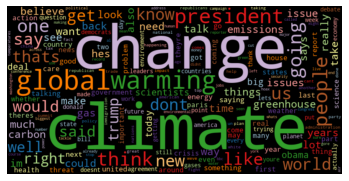

In [41]:
words = count_words(df)
wordcloud(words['freq'])

### Sentiment analysis with Textblob

In [45]:
df['polarity'] = df['Snippet'].apply(lambda x: TextBlob(x).polarity)
df['subjectivity'] = df['Snippet'].apply(lambda x: TextBlob(x).subjectivity)

In [48]:
df.sample(n=5)

,MatchDateTime,Station,Snippet,Tokens,polarity,subjectivity
191,2014-04-19 12:13:17,MSNBC,be required o solve this crisis. but i'm not s...,"[required, solve, crisis, im, sure, ready, mak...",-0.05,0.659722
12,2013-10-11 07:17:09,FOXNEWS,shorter lines at starbucks. i think that is an...,"[shorter, lines, starbucks, think, interesting...",0.50,0.500000
318,2019-03-21 02:49:32,BBCNEWS,he will be aware that that has already helped ...,"[aware, already, helped, 47, million, people, ...",0.25,0.250000
583,2019-08-27 10:38:42,CNN,"president, yeah. i kind of think so, joe, and ...","[president, yeah, kind, think, joe, gets, issu...",0.20,0.333333
126,2013-11-12 05:26:56,CNN,"this. frankly, i don't know why, dr. spencer, ...","[frankly, dont, know, dr, spencer, believe, do...",0.00,0.522222


### Topic modeling


In [27]:
# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(combined_tokens)
count_vectors.shape

(2106506, 16017)

In [28]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(combined_tokens)
tfidf_vectors.shape

(2106506, 16017)

#### LDA

In [31]:
## takes >25 minutes
# Fitting LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

# Display LDA Model
display_topics(lda_model, count_vectorizer.get_feature_names_out())

KeyboardInterrupt: 

In [ ]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_vectors, count_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

#### LDA w/ Gensim

In [23]:
# tokens stored in df['Recipe_tokens']
gensim_tokens = df['Tokens']

# initialize Gensim dictionary 
dict_gensim = Dictionary(gensim_tokens)

# filter for words that appear in: at least 5 but not more than 70% of all snippets
dict_gensim.filter_extremes(no_below=5, no_above=0.7)

# calculate bag of words matrix
bow_gensim = [dict_gensim.doc2bow(token) for token in gensim_tokens]

# perform TF-IDF transformation

tfidf_gensim = TfidfModel(bow_gensim)
vectors_gensim = tfidf_gensim[bow_gensim]

In [17]:
# using LDA with Gensim
lda_gensim = LdaModel (corpus = bow_gensim,
                       id2word = dict_gensim,
                       chunksize = 2000,
                       alpha = 'auto',
                       eta = 'auto',
                       iterations = 400,
                       num_topics = 5,
                       passes = 20,
                       eval_every = None,
                       random_state = 509)

In [18]:
# see word distribution of topics
#display_topics_gensim(lda_gensim)
lda_gensim_topics = lda_gensim.show_topics(num_topics=5, num_words=10)

# Display the topics
for topic_idx, topic in lda_gensim_topics:
    print(f"Topic #{topic_idx + 1}: {topic}")

Topic #1: 0.024*"world" + 0.018*"greenhouse" + 0.017*"new" + 0.017*"emissions" + 0.014*"carbon" + 0.013*"gas" + 0.011*"government" + 0.011*"action" + 0.010*"environment" + 0.010*"news"
Topic #2: 0.017*"weather" + 0.011*"facing" + 0.009*"record" + 0.008*"air" + 0.008*"water" + 0.008*"seen" + 0.008*"extreme" + 0.008*"across" + 0.007*"become" + 0.006*"finds"
Topic #3: 0.023*"president" + 0.021*"us" + 0.015*"said" + 0.014*"trump" + 0.010*"first" + 0.010*"today" + 0.009*"next" + 0.008*"two" + 0.008*"crisis" + 0.008*"hes"
Topic #4: 0.025*"global" + 0.023*"warming" + 0.020*"people" + 0.016*"think" + 0.014*"going" + 0.013*"like" + 0.013*"one" + 0.012*"say" + 0.010*"get" + 0.010*"would"
Topic #5: 0.024*"years" + 0.018*"year" + 0.017*"scientists" + 0.017*"could" + 0.012*"says" + 0.012*"report" + 0.010*"impact" + 0.009*"temperatures" + 0.008*"planet" + 0.008*"global"
